## 3.2 Decentralized Gradient Descent (Adapt-with-combination)

### 3.2.1 Problem and ATC-DGD

Consider $n$ computing nodes collaborate to solve the problem:

$$\min_{x\in \mathbb{R}^d} \quad \frac{1}{n}\sum_{i=1}^n f_i(x)$$

where $f_i(x)$ is a local and private function held by node $i$. Each node $i$ can access its own variable $x$ or gradient $\nabla f_i(x)$, but it has to communicate to access information from other nodes.

If each $f_i(x)$ is assumed to be smooth, the ATC-DGD has the following recursions

$$\begin{align}
x^{(k+1)} = \sum_{i=1}^n w_{ij} \Big(x_j^{(k)} - \alpha \nabla f_j(x_j^{(k)}) \Big) \quad \mbox{(ATC-DGD)}
\end{align}$$

### 3.2.2 Decentralized gradient descent (Adapt-with-combination)

This section discusses another form of decentralized gradient descent:

$$\begin{align}
x^{(k+1)} = \sum_{i=1}^n w_{ij} x_j^{(k)} - \alpha \nabla f_i(x_i^{(k)}) \quad \mbox{(AWC-DGD)}
\end{align}$$

Comparing with ATC-DGD, AWC-DGD mixes the combination and local adaptation within a single step. It is also worth noting that the combinination is not on the gradient, which is different from ATC-DGD. This will affects AWC-DGD's convergence slightly.

### 3.2.3 Convergence properties

The convergence property of AWC-DGD is very similar to that of ATC-DGD. For $L$-smooth and $\mu$-strongly convex problems, if the step-size $\alpha$ is sufficiently small, the ATC-DGD algorithm will converge as follows.

\begin{align}
\limsup_{k\to \infty} \frac{1}{n}\sum_{i=1}^n \|x_i^{(k)} - x^\star \|^2 = O\Big( (1-\alpha \mu)^{k} + \frac{\alpha^2  b^2}{(1-\rho)^2}\Big) \hspace{1cm} \mbox{(AWC-DGD-Convergence)}
\end{align}

where $x^\star$ is the glboal solution to the optimization problem, $\rho = \max\{|\lambda_2(W), \lambda_n(W)|\}$ and $b^2 = \frac{1}{n}\sum_{i=1}^n \|\nabla f_i(x^\star)\|^2$ denotes the data heterogeneity between nodes. Quantity $1-\rho$ measures the connectivity of the network topology. It is observed that AWC-DGD cannot converge exactly to the solution $x^\star$, but to a neighborhood around it. The limiting error is on the order of $O(\frac{\alpha^2 b^2}{(1-\rho)^2})$. When step-size $\alpha$ is small, or the data heterogeneity $b^2$ is small, or the network is well-connected, i.e., $\rho \to 0$, the limiting error can be negligible. 

<!-- It is also observed that the limiting bias of AWC-DGD $O(\frac{\alpha^2 b^2}{(1-\rho)^2})$ is slightly larger than the that of ATC-DGD $O(\frac{\alpha^2 \rho^2 b^2}{(1-\rho)^2})$ when the same step-size $\alpha$ is used. In addition, it is also proved in literature \[Refs\] that the step-size stability range  -->

### 3.2.4 An example: least-square problem

In this section, we will show a demo on how to solve a least-square problem with AWC-DGD using BlueFog. Suppose $n$ computing nodes collaborate to solve the following problem:

$$\min_x \quad \frac{1}{n}\sum_{i=1}^n \|A_i x - b_i\|^2$$

where $\{A_i, b_i\}$ are local data held in node $i$.

#### 3.2.4.1 Set up BlueFog

In the following code, you should be able to see the id of your CPUs. We use 8 CPUs to conduct the following experiment.

In [1]:
import ipyparallel as ipp

rc = ipp.Client(profile='bluefog')
rc.ids

[0, 1, 2, 3, 4, 5, 6, 7]

Let each agent import necessary modules and then initialize BlueFog. You should be able to see the printed information like:  

> \[stdout:0\] Hello, I am 1 among 8 processes
> 
> ...

In [2]:
%%px
import numpy as np
import bluefog.torch as bf
import torch
from bluefog.common import topology_util
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

bf.init()
print(f"Hello, I am {bf.rank()} among {bf.size()} processes")

[stdout:0] Hello, I am 4 among 8 processes
[stdout:1] Hello, I am 2 among 8 processes
[stdout:2] Hello, I am 5 among 8 processes
[stdout:3] Hello, I am 1 among 8 processes
[stdout:4] Hello, I am 3 among 8 processes
[stdout:5] Hello, I am 7 among 8 processes
[stdout:6] Hello, I am 6 among 8 processes
[stdout:7] Hello, I am 0 among 8 processes


Push seed to each agent so that the simulation can be reproduced.

In [3]:
dview = rc[:] # A DirectView of all engines
dview.block=True

# Push the data into all workers
dview.push({'seed': 2021}, block=True)

[None, None, None, None, None, None, None, None]

After running the following code, you should be able to see the printed information like 

> \[stdout:0\] I received seed as value:  2021
> 
> ...

In [4]:
%%px
print("I received seed as value: ", seed)

[stdout:0] I received seed as value:  2021
[stdout:1] I received seed as value:  2021
[stdout:2] I received seed as value:  2021
[stdout:3] I received seed as value:  2021
[stdout:4] I received seed as value:  2021
[stdout:5] I received seed as value:  2021
[stdout:6] I received seed as value:  2021
[stdout:7] I received seed as value:  2021


Congratulations! Your BlueFog is initialized and tested successfully.

#### 3.2.4.2 Generate local data $A_i$ and $b_i$

In [5]:
%%px

def generate_data(m, n):
    
    A = torch.randn(m, n).to(torch.double)
    x_o = torch.randn(n, 1).to(torch.double)
    ns = 0.1*torch.randn(m, 1).to(torch.double)
    b = A.mm(x_o) + ns
        
    return A, b

#### 3.2.4.3 Distributed gradient descent method

In [6]:
%%px

def distributed_grad_descent(A, b, maxite=5000, alpha=1e-1):

    x_opt = torch.zeros(n, 1, dtype=torch.double)

    for _ in range(maxite):
        # calculate local gradient 
        grad_local = A.t().mm(A.mm(x_opt) - b)
        
        # global gradient
        grad = bf.allreduce(grad_local, name='gradient')

        # distributed gradient descent
        x_opt = x_opt - alpha*grad

    grad_local = A.t().mm(A.mm(x_opt) - b)
    grad = bf.allreduce(grad_local, name='gradient')  # global gradient

    # evaluate the convergence of distributed gradient descent
    # the norm of global gradient is expected to 0 (optimality condition)
    global_grad_norm = torch.norm(grad, p=2)
    if bf.rank() == 0:
        print("[Distributed Grad Descent] Rank {}: global gradient norm: {}".format(bf.rank(), global_grad_norm))

    return x_opt

In the following code we run distributed gradient descent to achieve the global solution $x^\star$ to the optimization problem. To validate whether $x^\star$ is optimal, it is enough to examine $\frac{1}{n}\sum_{i=1}^n \nabla f_i(x^\star) = 0$.

In [7]:
%%px

m, n = 20, 5
A, b = generate_data(m, n)
x_opt = distributed_grad_descent(A, b, maxite=200, alpha=1e-2)

[stdout:7] [Distributed Grad Descent] Rank 0: global gradient norm: 3.2361430059369585e-14


#### 3.2.4.3 Decentralized gradient descent method

In this section, we depict the convergence curve of the decentralied gradient descent (the AWC version). We will utilize the $x^\star$ achieved by distributed gradient descent as the optimal solution. First, we define one step of the AWC-DGD method.

In [8]:
%%px 

def AWC_DGD_one_step(x, x_opt, A, b, alpha=1e-2):
    
    # one-step ATC-DGD. 
    # The combination weights have been determined by the associated combination matrix.
    
    grad_local = A.t().mm(A.mm(x) - b)                       # compute local grad
    x_new = bf.neighbor_allreduce(x) - alpha*grad_local      # AWC update
    
    # the relative error: |x^k-x_gloval_average|/|x_gloval_average|
    rel_error = torch.norm(x_new-x_opt, p=2)/torch.norm(x_opt,p=2)

    return x_new, rel_error

Next we run AWC-DGD algorithm.

In [30]:
%%px

# Set topology as exponential-two topology.
G = topology_util.ExponentialTwoGraph(bf.size())
bf.set_topology(G)

maxite = 500
x = torch.zeros(n, 1, dtype=torch.double)     # Initialize x
rel_error = torch.zeros((maxite, 1))
for ite in range(maxite):
    
    if bf.rank()==0:
        if ite%10 == 0:
            print('Progress {}/{}'.format(ite, maxite))
        
    x, rel_error[ite] = AWC_DGD_one_step(x, x_opt, A, b, alpha=5e-4) # you can adjust alpha to different values

[stdout:7] 
Progress 0/500
Progress 10/500
Progress 20/500
Progress 30/500
Progress 40/500
Progress 50/500
Progress 60/500
Progress 70/500
Progress 80/500
Progress 90/500
Progress 100/500
Progress 110/500
Progress 120/500
Progress 130/500
Progress 140/500
Progress 150/500
Progress 160/500
Progress 170/500
Progress 180/500
Progress 190/500
Progress 200/500
Progress 210/500
Progress 220/500
Progress 230/500
Progress 240/500
Progress 250/500
Progress 260/500
Progress 270/500
Progress 280/500
Progress 290/500
Progress 300/500
Progress 310/500
Progress 320/500
Progress 330/500
Progress 340/500
Progress 350/500
Progress 360/500
Progress 370/500
Progress 380/500
Progress 390/500
Progress 400/500
Progress 410/500
Progress 420/500
Progress 430/500
Progress 440/500
Progress 450/500
Progress 460/500
Progress 470/500
Progress 480/500
Progress 490/500


In [31]:
# collect relative error from node 0 for step-size 2e-3
rel_error_exp2_alpha2em3 = dview.pull('rel_error', block=True, targets=0)

In [21]:
# collect relative error from node 0 for step-size 1e-3
rel_error_exp2_alpha1em3 = dview.pull('rel_error', block=True, targets=0)

In [25]:
# collect relative error from node 0 for step-size 5e-4
rel_error_exp2_alpha5em4 = dview.pull('rel_error', block=True, targets=0)

Text(0, 0.5, 'Relative error')

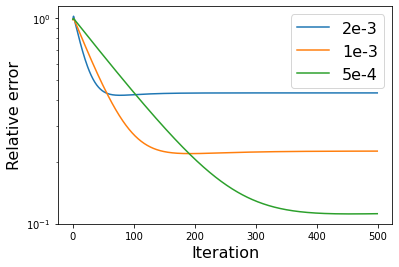

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.semilogy(rel_error_exp2_alpha2em3)
plt.semilogy(rel_error_exp2_alpha1em3)
plt.semilogy(rel_error_exp2_alpha5em4)

plt.legend(['2e-3', '1e-3', '5e-4'], fontsize=16)

plt.xlabel('Iteration', fontsize=16)
plt.ylabel('Relative error', fontsize=16)

It is observed from the above figures that smaller alpha can lead to more accuate solution, but the convergence rate will get slower. This observation is consistent with Eq. (DGD-Convergence).